<a href="https://colab.research.google.com/github/Navneeth08k/dayTradingModel/blob/main/gradient_boosting_daytrade_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
pip install numpy pandas matplotlib scikit-learn xgboost lightgbm catboost


In [62]:
import requests

API_KEY = 'P0PT12F4WRKB4SLW'
symbol = 'AAPL'
url = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={symbol}&interval=1min&apikey={API_KEY}'
response = requests.get(url)
data = response.json()


In [63]:
import pandas as pd

df = pd.DataFrame(data['Time Series (1min)']).T
df.columns = ['open', 'high', 'low', 'close', 'volume']
df = df.apply(pd.to_numeric)
df.index = pd.to_datetime(df.index)


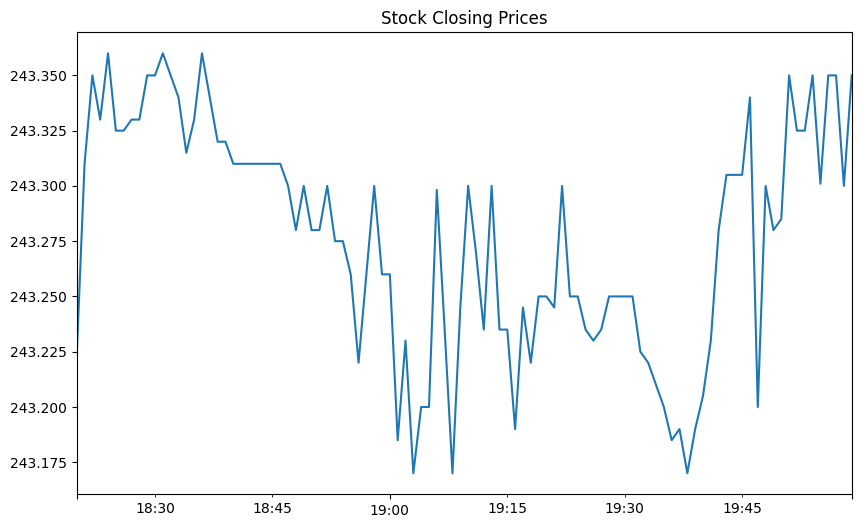

In [64]:
import matplotlib.pyplot as plt

df['close'].plot(figsize=(10, 6))
plt.title('Stock Closing Prices')
plt.show()


In [99]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

# Handle NaN values by dropping them
df['volume_ma_5'] = df['volume'].rolling(window=5).mean()
df['obv'] = (df['close'] > df['close'].shift(1)) * df['volume'] - (df['close'] < df['close'].shift(1)) * df['volume']
df['obv'] = df['obv'].cumsum()
df['vroc'] = (df['volume'] - df['volume'].shift(5)) / df['volume'].shift(5)
df['sma_5'] = df['close'].rolling(window=5).mean()
df['ema_5'] = df['close'].ewm(span=5, adjust=False).mean()
delta = df['close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
df['rsi'] = 100 - (100 / (1 + gain / loss))
df['bb_upper'] = df['close'].rolling(window=20).mean() + 2 * df['close'].rolling(window=20).std()
df['bb_lower'] = df['close'].rolling(window=20).mean() - 2 * df['close'].rolling(window=20).std()
df['high_low_spread'] = df['high'] - df['low']
df['proc'] = (df['close'] - df['close'].shift(5)) / df['close'].shift(5)


X = df[['volume', 'open', 'high', 'low', 'volume_ma_5', 'obv', 'sma_5', 'rsi', 'bb_upper', 'bb_lower', 'high_low_spread', 'proc', 'vroc']]

y = (df['close'].shift(-1) > df['close']).astype(int)  # Labels: 1 if price goes up, else 0
originalDF = df.copy()
# Drop rows with NaN values before splitting
df.dropna(inplace=True)

# Now split the data after dropping NaNs
X_train, X_test, y_train, y_test = train_test_split(df[['volume', 'open', 'high', 'low', 'volume_ma_5', 'obv', 'sma_5', 'rsi', 'bb_upper', 'bb_lower', 'high_low_spread', 'proc', 'vroc']], df['close'].shift(-1) > df['close'], test_size=0.2, random_state=42)


model = GradientBoostingClassifier()
model.fit(X_train, y_train)
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

print(f"Model Accuracy: {model.score(X_test, y_test):.2f}")

from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1,0.2,0.3],
    'max_depth': [3, 5, 7,9],
    'n_estimators': [50, 100, 200,300]
}
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)

df = originalDF.copy()

[[6 4]
 [3 4]]
              precision    recall  f1-score   support

       False       0.67      0.60      0.63        10
        True       0.50      0.57      0.53         7

    accuracy                           0.59        17
   macro avg       0.58      0.59      0.58        17
weighted avg       0.60      0.59      0.59        17

Model Accuracy: 0.59
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}


            Feature  Importance
12             vroc    0.219651
9          bb_lower    0.119828
7               rsi    0.103426
11             proc    0.092320
4       volume_ma_5    0.082550
0            volume    0.074886
1              open    0.072430
6             sma_5    0.067985
8          bb_upper    0.067707
3               low    0.045544
5               obv    0.035331
10  high_low_spread    0.018271
2              high    0.000070


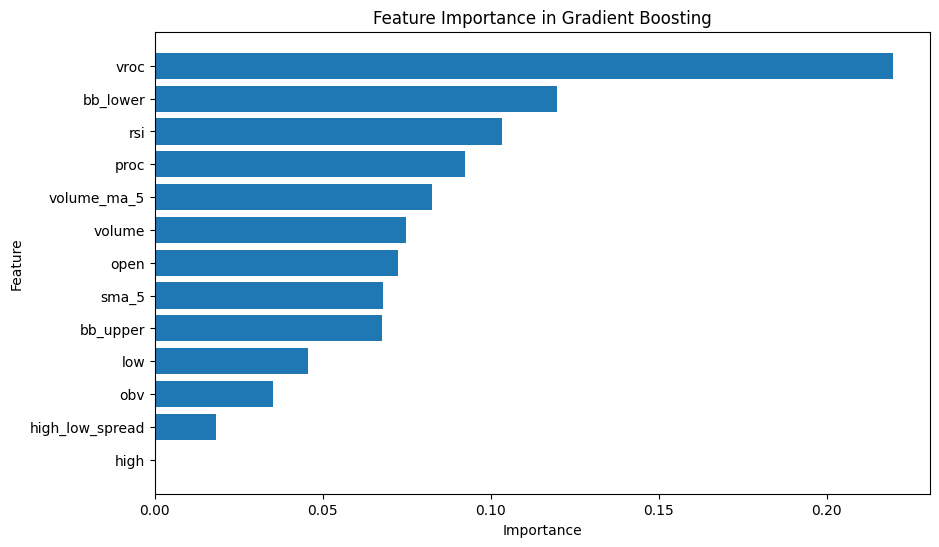

In [95]:
# Display feature importance
importance = model.feature_importances_

# Create a DataFrame for better visualization
feature_names = X.columns
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

print(importances_df)


#visulazation of importance
import matplotlib.pyplot as plt

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importances_df['Feature'], importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Gradient Boosting')
plt.gca().invert_yaxis()  # Invert axis to show most important features on top
plt.show()



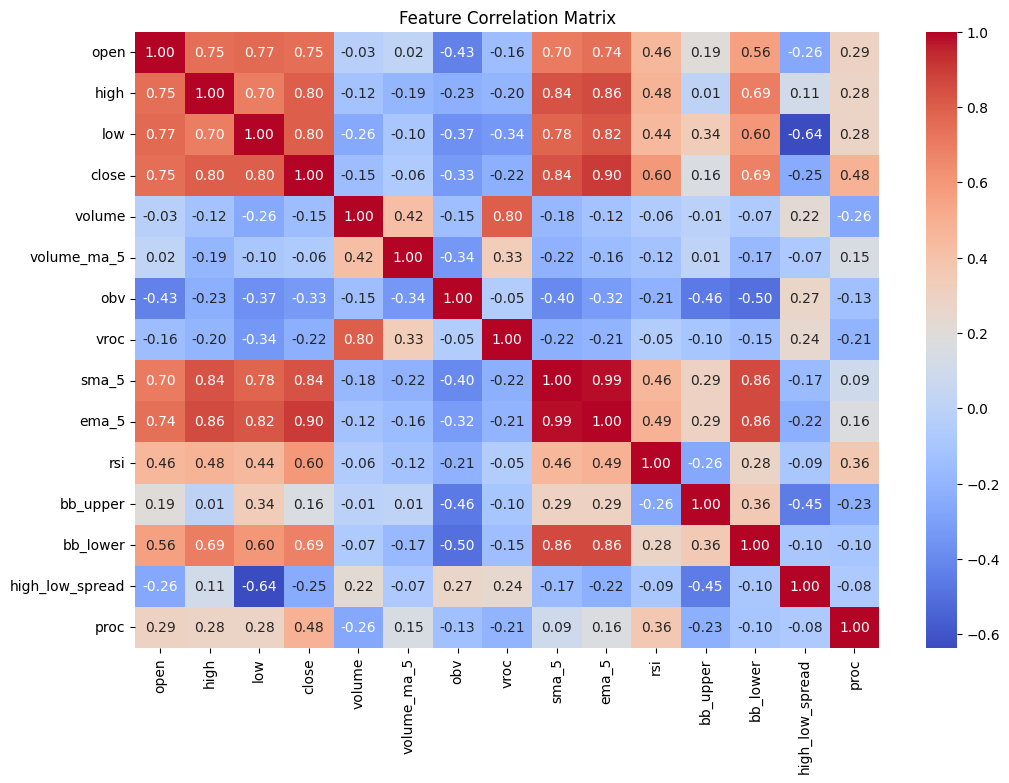

In [96]:
correlation_matrix = df.corr()
import matplotlib.pyplot as plt
import seaborn as sns

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()
